In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
#Importing the dataset
df=pd.read_csv("INFY.csv")
df['Volume']=df['Volume'].astype('float64')

In [3]:
#Converting the date to datetime datatype
df['Date']=pd.to_datetime(df['Date'])

In [4]:
#Generating technical indicators for the data
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

In [7]:
# Define the period for RSI calculation (e.g., 14 days)
period = 14

# Calculate daily price changes
delta = df['Close'].diff()

# Calculate gains and losses
gains = delta.where(delta > 0, 0)
losses = -delta.where(delta < 0, 0)

# Calculate average gains and losses over the specified period
average_gain = gains.rolling(window=period).mean()
average_loss = losses.rolling(window=period).mean()

# Calculate RSI
rs = average_gain / average_loss
rsi = 100 - (100 / (1 + rs))

# Add RSI to the DataFrame
df['RSI'] = rsi


In [ ]:
# Calculate the short-term EMA (e.g., 12-day EMA)
short_ema = df['Close'].ewm(span=12, adjust=False).mean()

# Calculate the long-term EMA (e.g., 26-day EMA)
long_ema = df['Close'].ewm(span=26, adjust=False).mean()

# Calculate MACD line
macd_line = short_ema - long_ema

# Calculate the signal line (e.g., 9-day EMA of the MACD line)
signal_line = macd_line.ewm(span=9, adjust=False).mean()

# Add MACD and signal line to the DataFrame
df['MACD'] = macd_line
df['Signal_Line'] = signal_line

In [8]:
# Define the number of days ahead you want to predict (e.g., 1 day)
days_ahead = 1

# Create a new column 'Target_Close' with the closing price shifted by 'days_ahead'
df['Target_Close'] = df['Close'].shift(-days_ahead)

# Drop rows with NaN values (last rows with no future data)
df.dropna(subset=['Target_Close'], inplace=True)


In [9]:
# Create a new column 'Price_Direction' with 1 for an increase and 0 for a decrease or no change
df['Price_Direction'] = (df['Close'] - df['Close'].shift(1)) > 0
df['Price_Direction'] = df['Price_Direction'].astype(int)

# Drop the first row (NaN due to shifting)
df = df.iloc[1:]

#Drop the NaN values
df.dropna(inplace=True)

In [11]:

# Split the dataset into features (X) and the target variable (y)
X = df.drop(columns=['Target_Close', 'Price_Direction','Date'])
y = df['Target_Close']  # Choose the appropriate target variable

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=123)


# Print the shapes of the resulting sets to verify the split
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (4279, 13) (4279,)
Validation set shape: (917, 13) (917,)
Test set shape: (917, 13) (917,)


Validation Mean Squared Error: 0.04125697615099299


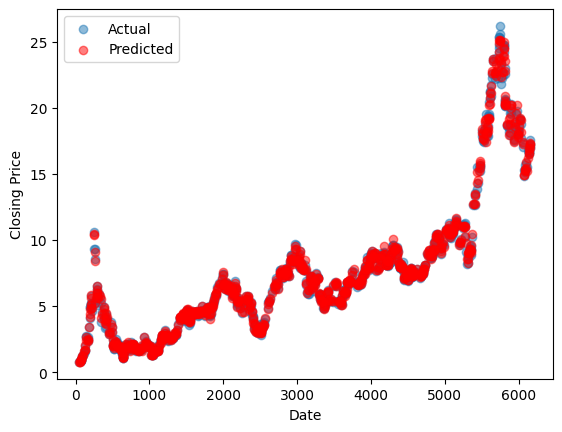

In [16]:
rf_model = RandomForestRegressor(random_state=42,max_depth=10,min_samples_leaf=4,min_samples_split=2,n_estimators=200)

rf_model.fit(X_train, y_train)

y_val_pred = rf_model.predict(X_val)

mse = mean_squared_error(y_val, y_val_pred)
print(f"Validation Mean Squared Error: {mse}")

# Plot actual vs. predicted values
plt.scatter(y_val.index, y_val, label='Actual', alpha=0.5)
plt.scatter(y_val.index, y_val_pred, label='Predicted', color='red', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()
